In [1]:
# 🔧 Add root to sys.path for module imports (Jupyter-safe)
import sys
from pathlib import Path

ROOT = Path.cwd().parent.parent  # Go up from /notebooks/ → experiment → project root
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"[INFO] Added ROOT to sys.path: {ROOT}")
 

[INFO] Added ROOT to sys.path: /home/arsalan/wsu-grid/ml-jet-param-predictor


In [2]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
# from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.training_loop import run_training_loop
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.scheduler_utils import create_scheduler
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


In [ ]:
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_25072401_hybrid_mamaba_vit_stack/config/" \
# "hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs16_ep50_lr1e-04_ds1008_g500_sched-RLRP.yml")

# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_25072401_hybrid_mamaba_vit_stack/config/" \
# "hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs16_ep50_lr1e-04_ds1000_g1_sched-RLRP.yml")

cfg=get_config()
# print(cfg)
print(json.dumps(vars(cfg), indent=2))


[INFO] Config Path: /home/arsalan/wsu-grid/ml-jet-param-predictor/experiments/exp_25072401_hybrid_mamaba_vit_stack/config/hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs16_ep50_lr1e-04_ds1000_g1_sched-RLRP.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Using dataset_size from config: 1000
{
  "model_tag": "mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500",
  "backbone": [
    "mambaout_base_plus_rw",
    "vit_tiny_patch16_224"
  ],
  "batch_size": 16,
  "epochs": 50,
  "learning_rate": 0.0001,
  "patience": 12,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unsh

In [4]:
device = get_device_summary()

=== NVIDIA-SMI ===
Mon Jul 28 17:26:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
| 30%   35C    P5              26W / 220W |    779MiB /  8192MiB |     23%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [5]:
from experiments.exp_25072401_hybrid_mamaba_vit_stack.models.hybrid_mamba_vit import create_model

In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

Using Hybrid Mamba ➝ ViT model: mambaout_base_plus_rw → vit_tiny_patch16_224


MambaToViTClassifier(
  (input_proj): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (mamba): FeatureListNet(
    (stem): Stem(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU()
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages_0): MambaOutStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (fc1): Linear(in_features=128, out_features=768, bias=True)
          (act): SiLU()
          (conv): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (fc2): Linear(in_features=384, out_features=128, bias=True)
          (ls): LayerScale()
          (drop_path): Identity()
        )
        (1): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementwis

In [7]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 50
[INFO] Length of validation dataloader: 6
[INFO] Length of test dataloader: 7


In [8]:
if torch.cuda.device_count() > 1:
    print(f"Parallelizing model across {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
elif torch.cuda.device_count() == 1:
    print("No parallelization, using single GPU")
elif torch.cuda.device_count() == 0:
    print("No GPU available, using CPU")

No parallelization, using single GPU


In [9]:
scheduler = create_scheduler(optimizer, cfg, train_loader=train_loader)

In [10]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [11]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [12]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs16_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json


In [13]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [14]:
best_epoch,best_acc,best_metrics=run_training_loop(
                      cfg,train_loader,val_loader,
                      device, model,criterion,
                      optimizer,scheduler,
                      start_epoch,early_stop_counter,
                      best_acc,best_metrics,best_epoch,
                      train_loss_list,
                        train_loss_energy_list,
                        train_loss_alpha_list,
                        train_loss_q0_list,
                        train_acc_list,
                        train_acc_energy_list,
                        train_acc_alpha_list,
                        train_acc_q0_list,
                        val_loss_list,
                        val_loss_energy_list,
                        val_loss_alpha_list,
                        val_loss_q0_list,
                        val_acc_list,
                        val_acc_energy_list,
                        val_acc_alpha_list,
                        val_acc_q0_list,
                        all_epoch_metrics)

[INFO] Epoch 1/50


[INFO] Epoch 1: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 1: Energy Loss =0.5739, αs Loss = 1.1078, Q0 Loss = 1.4108, Total Loss = 3.0925
📉 Current LR: 0.0001
[INFO] Epoch 1: Saving metrics to disk
💾 Last model saved at epoch 1
✅ Best model saved at epoch 1 with total accuracy: 0.0833
[INFO] Epoch 2/50


[INFO] Epoch 2: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 2: Energy Loss =0.5625, αs Loss = 1.0987, Q0 Loss = 1.4362, Total Loss = 3.0974
📉 Current LR: 0.0001
[INFO] Epoch 2: Saving metrics to disk
💾 Last model saved at epoch 2
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 3/50


[INFO] Epoch 3: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 3: Energy Loss =0.5722, αs Loss = 1.1135, Q0 Loss = 1.4084, Total Loss = 3.0941
📉 Current LR: 0.0001
[INFO] Epoch 3: Saving metrics to disk
💾 Last model saved at epoch 3
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 4/50


[INFO] Epoch 4: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 4: Energy Loss =0.5675, αs Loss = 1.1024, Q0 Loss = 1.4048, Total Loss = 3.0748
📉 Current LR: 0.0001
[INFO] Epoch 4: Saving metrics to disk
💾 Last model saved at epoch 4
⏳ No improvement. Early stop counter: 3/12
[INFO] Epoch 5/50


[INFO] Epoch 5: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 5: Energy Loss =0.5649, αs Loss = 1.1157, Q0 Loss = 1.3911, Total Loss = 3.0718
📉 Current LR: 0.0001
[INFO] Epoch 5: Saving metrics to disk
💾 Last model saved at epoch 5
⏳ No improvement. Early stop counter: 4/12
[INFO] Epoch 6/50


[INFO] Epoch 6: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 6: Energy Loss =0.5644, αs Loss = 1.1001, Q0 Loss = 1.4067, Total Loss = 3.0713
📉 Current LR: 5e-05
[INFO] Epoch 6: Saving metrics to disk
💾 Last model saved at epoch 6
⏳ No improvement. Early stop counter: 5/12
[INFO] Epoch 7/50


[INFO] Epoch 7: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 7: Energy Loss =0.5631, αs Loss = 1.1047, Q0 Loss = 1.3907, Total Loss = 3.0585
📉 Current LR: 5e-05
[INFO] Epoch 7: Saving metrics to disk
💾 Last model saved at epoch 7
⏳ No improvement. Early stop counter: 6/12
[INFO] Epoch 8/50


[INFO] Epoch 8: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 8: Energy Loss =0.5632, αs Loss = 1.1032, Q0 Loss = 1.3930, Total Loss = 3.0595
📉 Current LR: 5e-05
[INFO] Epoch 8: Saving metrics to disk
💾 Last model saved at epoch 8
⏳ No improvement. Early stop counter: 7/12
[INFO] Epoch 9/50


[INFO] Epoch 9: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 9: Energy Loss =0.5624, αs Loss = 1.1007, Q0 Loss = 1.3882, Total Loss = 3.0513
📉 Current LR: 5e-05
[INFO] Epoch 9: Saving metrics to disk
💾 Last model saved at epoch 9
⏳ No improvement. Early stop counter: 8/12
[INFO] Epoch 10/50


[INFO] Epoch 10: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 10: Energy Loss =0.5639, αs Loss = 1.1007, Q0 Loss = 1.3906, Total Loss = 3.0552
📉 Current LR: 5e-05
[INFO] Epoch 10: Saving metrics to disk
💾 Last model saved at epoch 10
⏳ No improvement. Early stop counter: 9/12
[INFO] Epoch 11/50


[INFO] Epoch 11: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 11: Energy Loss =0.5624, αs Loss = 1.1034, Q0 Loss = 1.3900, Total Loss = 3.0559
📉 Current LR: 2.5e-05
[INFO] Epoch 11: Saving metrics to disk
💾 Last model saved at epoch 11
⏳ No improvement. Early stop counter: 10/12
[INFO] Epoch 12/50


[INFO] Epoch 12: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 12: Energy Loss =0.5625, αs Loss = 1.0997, Q0 Loss = 1.3872, Total Loss = 3.0495
📉 Current LR: 2.5e-05
[INFO] Epoch 12: Saving metrics to disk
💾 Last model saved at epoch 12
⏳ No improvement. Early stop counter: 11/12
[INFO] Epoch 13/50


[INFO] Epoch 13: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 13: Energy Loss =0.5623, αs Loss = 1.1025, Q0 Loss = 1.3866, Total Loss = 3.0514
📉 Current LR: 2.5e-05
[INFO] Epoch 13: Saving metrics to disk
💾 Last model saved at epoch 13
⏳ No improvement. Early stop counter: 12/12
🛑 Early stopping triggered at epoch 13. Best was at epoch 1.


In [15]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs16_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json

🏁 Best Model @ Epoch 1
Total Accuracy: 0.0833

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.3333
  Precision: 0.1111
  Recall   : 0.3333
  F1-Score : 0.1667

🔹 Q0 Task
  Accuracy : 0.2500
  Precision: 0.0625
  Recall   : 0.2500
  F1-Score : 0.1000


📊 Plots saved to:
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs16_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.png
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs16_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.pdf


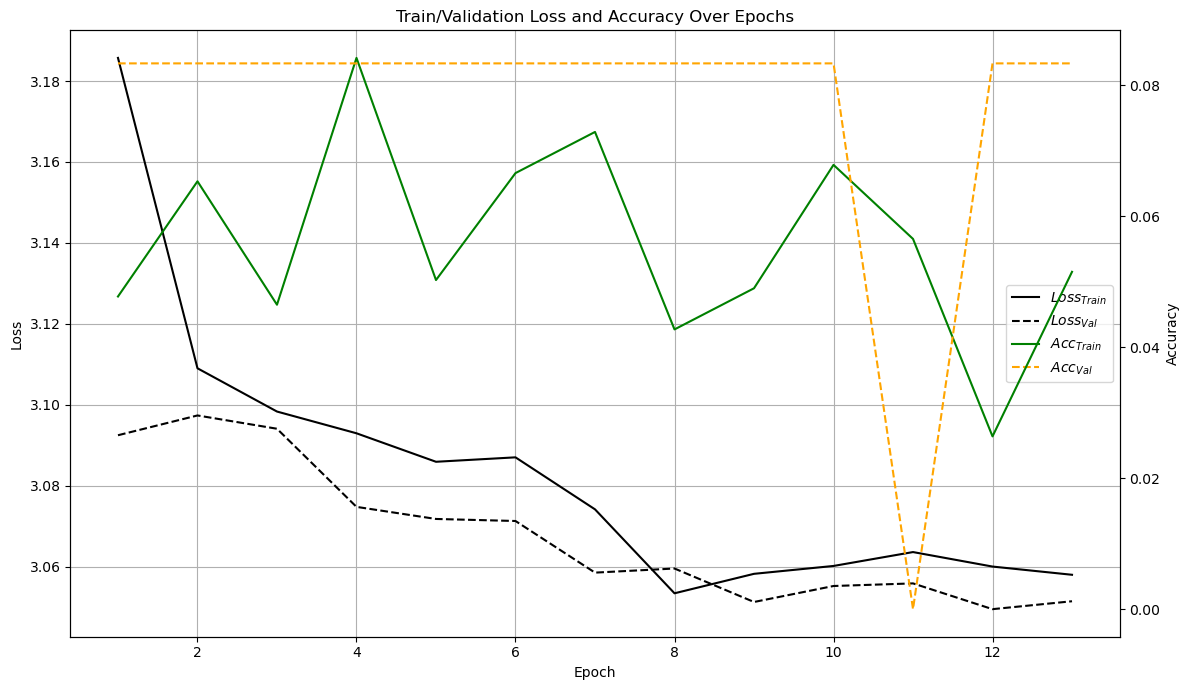

📉 Loss plot saved as:
  - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs16_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs16_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.pdf


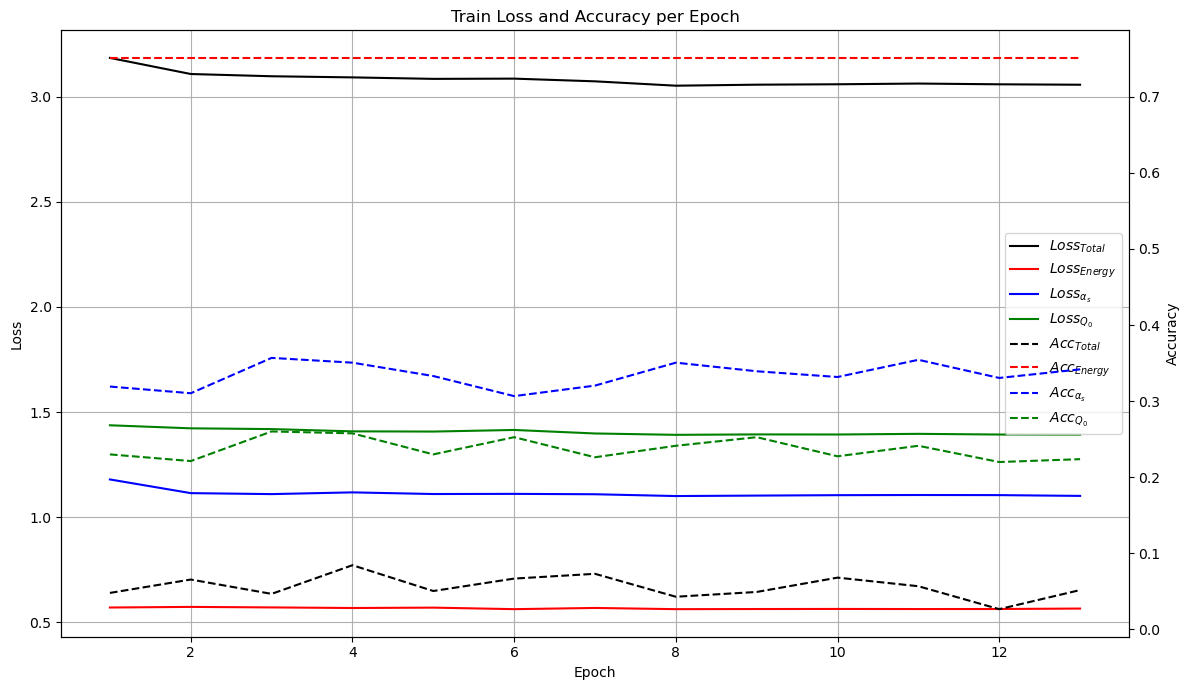

📉 Loss plot saved as:
  - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs16_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs16_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.pdf


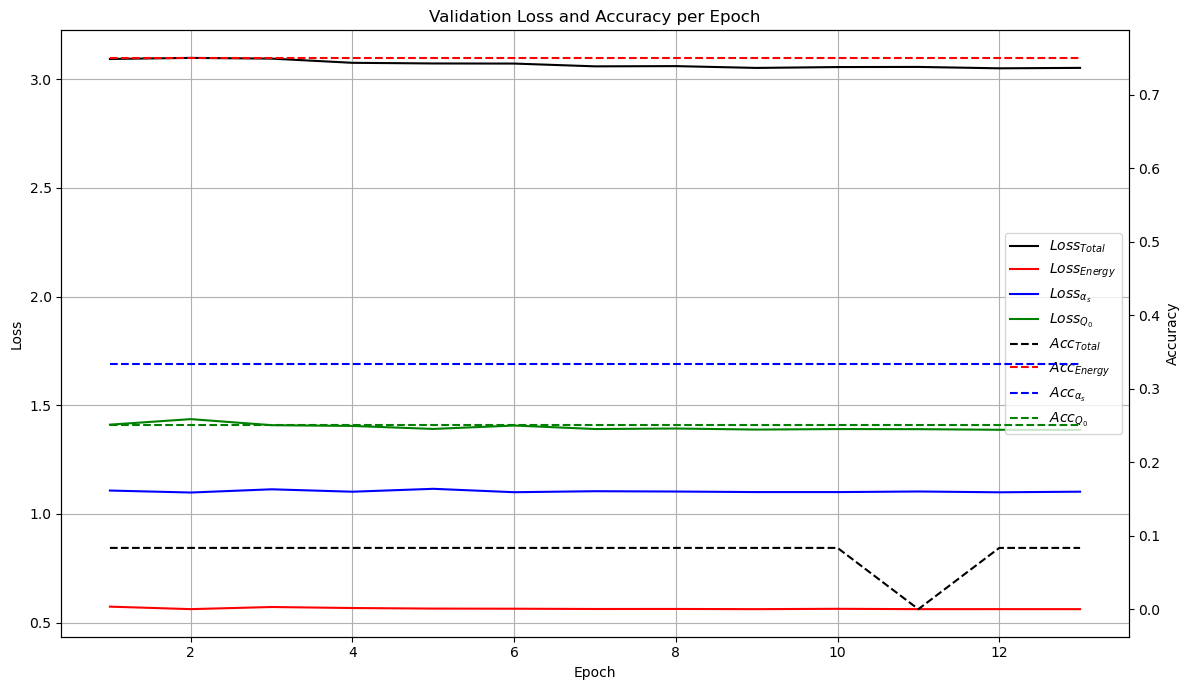

In [16]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")